In [1]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #03 - Statistical Objective Analysis

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using statistical objective analysis.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [36]:
## Import Required Modules ##
import numpy as np                 
import matplotlib.pyplot as plt    
import cartopy.crs as ccrs         
import cartopy.feature as cfeature 

In [37]:
## Bilinear interpolation function ##
def bilinear_interpolate(x, y, analysis):
    interpolated_bivals = np.zeros(xob.shape)
    for i in range(len(xob)):
        ob_indy = (yob[i]-y0)/del_y
        ob_indx = (xob[i]-x0)/del_x
        if ob_indx > 21 or ob_indx < 0 or ob_indy > 27 or ob_indy < 0:
            interpolated_bivals[i] = 0
        else:
            bl_indy = np.floor(ob_indy).astype(int)
            bl_indx = np.floor(ob_indx).astype(int)
            br_indy = np.floor(ob_indy).astype(int)
            br_indx = np.floor(bl_indx + 1).astype(int)
            tl_indy = np.floor(bl_indy + 1).astype(int)
            tl_indx = np.floor(ob_indx).astype(int)
            tr_indy = np.floor(bl_indy + 1).astype(int)
            tr_indx = np.floor(bl_indx + 1).astype(int)
            left_value = analysis[bl_indy, bl_indx] + ((analysis[tl_indy, tl_indx] -  analysis[bl_indy, bl_indx]) / (tl_indy - bl_indy)) * (ob_indy - bl_indy)
            right_value = analysis[br_indy, br_indx] + ((analysis[tr_indy, tr_indx] -  analysis[br_indy, br_indx]) / (tr_indy - br_indy)) * (ob_indy - br_indy)
            bilinear_val = left_value + ((right_value - left_value) / 1) * (ob_indx - bl_indx)
            interpolated_bivals[i] = bilinear_val
    return interpolated_bivals

In [38]:
## A fun and different bilinear ##
def simple_bilinear(x, y, analysis):
    interpolated_simpbivals = np.zeros(xob.shape)
    x_rel = x -int(np.floor(x))
    y_rel = y - int(np.floor(y))
    z1 = analysis[int(np.floor(y)), int(np.floor(x))]
    z2 = analysis[int(np.ceil(y)), int(np.floor(x))]
    z3 = analysis[int(np.ceil(y)), int(np.ceil(x))]
    z4 = analysis[int(np.floor(y)), int(np.ceil(x))]
    
    interpolated_simpbivals =(((x_rel-1)*(y_rel-1)*z1) - ((x_rel)*(y_rel-1)*z2) + (((x_rel)*(y_rel))*z3) - ((x_rel-1)*(y_rel)*z4))
    return interpolated_simpbivals

In [39]:
## Barnes Functions ##
def barnes(xob, yob, xg, yg, analysis):
    interpolated_bavals = np.zeros(xob.shape)
    weights_matrix = np.zeros(xob.shape)
    for i in range(xob.shape[0]):
        for j in range(xg.shape[1]):
            distances = np.sqrt((xob - xg[i,j])**2 + 
                                (yob - yg[i,j])**2)
            if np.any(distances < re): 
                barnes_weights = np.exp((-distances**2)/Kd)
                weights_matrix[i,j] = np.sum(barnes_weights)
                interpolated_bavals[i,j] = np.sum(barnes_weights * analysis) / weights_matrix[i,j]
    return interpolated_bavals
    
def simple_barnes(dik, R):
    if(dik<= R):
        weight = np.exp((-dik**2)/Kd)
    elif(dik > R):
        weight = 0
    return weight

In [40]:
## Read in observations ##
AllData = np.loadtxt('RAOBs_201903131200.txt',dtype='str')

Lat = np.ones((np.size(AllData)))*np.nan
Lon = np.ones((np.size(AllData)))*np.nan
GeoHeight = np.ones((np.size(AllData)))*np.nan
WindDir = np.ones((np.size(AllData)))*np.nan
WindSpd = np.ones((np.size(AllData)))*np.nan

for i in range(0,np.size(AllData)):
    Data = AllData[i].split(',')
    Lat[i] = float(Data[1])
    Lon[i] = float(Data[2])
    GeoHeight[i] = float(Data[3])
    WindDir[i] = float(Data[4])
    WindSpd[i] = float(Data[5])

In [41]:
## Set up analysis map with a 22x28 rectangular grid of points ##
x0 = 18.9
y0 = -6.3
del_x = 1.27
del_y = 1.27
x = x0 + np.arange(22) * del_x
y = y0 + np.arange(28) * del_y
xg, yg = np.meshgrid(x,y)

In [42]:
## convert obs lat/long to x,y + all the random variables ##
rho = 6371
lambda0 = -115
lambda0_r = np.radians(lambda0)
phi0 = 60
phi0_r = np.radians(phi0)
phi_scale_r = np.radians(40)
map_scale = 1/15000000
Kd = 10.8844524 
re = 12.7775892 
rho_0 = 0.95
b = 1.24

Lat_r = np.radians(Lat)
Lon_r = np.radians(Lon)

xkm = rho * (((1 + np.sin(phi0_r))/(1 + np.sin(Lat_r))) * np.cos(Lat_r) * np.cos(Lon_r - lambda0_r))
ykm = rho * (((1 + np.sin(phi0_r))/(1 + np.sin(Lat_r))) * np.cos(Lat_r) * np.sin(Lon_r - lambda0_r))

xcm = xkm * 1E5
ycm = ykm * 1E5

xob = xcm * map_scale
yob = ycm * map_scale

yg_earth = yg / map_scale / 1E5
xg_earth = xg / map_scale / 1E5

Lat_g = np.degrees((np.pi/2) - 2*np.arctan( np.sqrt(xg_earth**2 + yg_earth**2) / (rho*(1+np.sin(phi0_r) ) )))
Lon_g = lambda0 + np.degrees(np.arctan(yg_earth/xg_earth))

In [43]:
## Background field ##
background_matrix = np.zeros_like(xg)
weights_matrix = np.zeros_like(xg)
for i in range(xg.shape[0]):
    for j in range(xg.shape[1]):
        distances = np.sqrt((xob - xg[i, j])**2 + 
                            (yob - yg[i, j])**2)
        if np.any(distances < re): 
            barnes_weights = np.exp((-distances**2)/Kd)
            weights_matrix[i, j] = np.sum(barnes_weights)
            background_matrix[i, j] = np.sum(barnes_weights * GeoHeight) / weights_matrix[i, j]

In [44]:
## Finding fbrk ##
bilinear_analysis = np.zeros_like(xob)
bilinear_analysis = bilinear_interpolate(xob, yob, background_matrix)
fbrk = np.zeros_like(xob)
for i in range(xob.shape[0]):
    if bilinear_analysis[i] > 0:
        fbrk[i] = bilinear_analysis[i]
    else:

        distances = np.sqrt((xob[i] - xg)**2 + 
                            (yob[i] - yg)**2)
        if np.any(distances < re): 
            barnes_weights = np.exp((-distances**2)/Kd)
            weights_matrix = np.sum(barnes_weights)
            fbrk[i] = np.sum(barnes_weights * background_matrix) / weights_matrix
        else:
            fbrk[i] = np.nan

In [45]:
## First analysis for N=2 ##
N2 = 2
b_prime = 1.24*(1+np.sin(phi_scale_r))/(1+np.sin(phi0_r))
analysis2 = np.zeros_like(xg)
ob_pos = np.column_stack((xob, yob))
for i in range(xg.shape[0]):
    for j in range(xg.shape[1]):
        distances = np.sqrt((xob - xg[i, j])**2 + (yob - yg[i, j])**2)
        sorted_indices = np.argsort(distances)[:N2]
        nearest_obs_positions = ob_pos[sorted_indices]
        nearest_obs_values = GeoHeight[sorted_indices]
        nearest_background_values = fbrk[sorted_indices]
        correlations = np.zeros((N2, N2))
        dik = distances[sorted_indices]*1E-8 / map_scale
        rho_ik = rho_0*np.exp(-b_prime*(dik**2))
        for k in range(N2):
            for l in range(N2):             
                distance = np.linalg.norm(nearest_obs_positions[k] - nearest_obs_positions[l])
                s = distance * (1E-8/map_scale)
                correlations[k, l] = rho_0 * np.exp(-b_prime * s **2)
                if distance <= 1e-8:
                    correlations[k, l] = 1.0
        correlations=np.matrix(correlations)
        rho_ik = np.matrix(rho_ik)
        weights = (np.linalg.inv(correlations)*rho_ik.T).T
        summation = np.nansum(np.array(weights) * (nearest_obs_values - nearest_background_values))
        analysis2[i, j] = background_matrix[i,j] + summation

In [17]:
## Second analysis for N=4 ##
N4 = 4
b_prime = 1.24*(1+np.sin(phi_scale_r))/(1+np.sin(phi0_r))
analysis4 = np.zeros_like(xg)
ob_pos = np.column_stack((xob, yob))
for i in range(xg.shape[0]):
    for j in range(xg.shape[1]):
        distances = np.sqrt((xob - xg[i, j])**2 + (yob - yg[i, j])**2)
        sorted_indices = np.argsort(distances)[:N4]
        nearest_obs_positions = ob_pos[sorted_indices]
        nearest_obs_values = GeoHeight[sorted_indices]
        nearest_background_values = fbrk[sorted_indices]
        correlations = np.zeros((N4, N4))
        dik = distances[sorted_indices]*1E-8 / map_scale
        rho_ik = rho_0*np.exp(-b_prime*(dik**2))
        for k in range(N4):
            for l in range(N4):             
                distance = np.linalg.norm(nearest_obs_positions[k] - nearest_obs_positions[l])
                s = distance * (1E-8/map_scale)
                correlations[k, l] = rho_0 * np.exp(-b_prime * s **2)
                if distance <= 1e-8:
                    correlations[k, l] = 1.0
        correlations=np.matrix(correlations)
        rho_ik = np.matrix(rho_ik)
        weights = (np.linalg.inv(correlations)*rho_ik.T).T
        summation = np.nansum(np.array(weights) * (nearest_obs_values - nearest_background_values))
        analysis4[i, j] = background_matrix[i,j] + summation

In [15]:
## Third analysis for N=10 ##
N10 = 10
b_prime = 1.24*(1+np.sin(phi_scale_r))/(1+np.sin(phi0_r))
analysis10 = np.zeros_like(xg)
ob_pos = np.column_stack((xob, yob))
for i in range(xg.shape[0]):
    for j in range(xg.shape[1]):
        distances = np.sqrt((xob - xg[i, j])**2 + (yob - yg[i, j])**2)
        sorted_indices = np.argsort(distances)[:N10]
        nearest_obs_positions = ob_pos[sorted_indices]
        nearest_obs_values = GeoHeight[sorted_indices]
        nearest_background_values = fbrk[sorted_indices]
        correlations = np.zeros((N10, N10))
        dik = distances[sorted_indices]*1E-8 / map_scale
        rho_ik = rho_0*np.exp(-b_prime*(dik**2))
        for k in range(N10):
            for l in range(N10):             
                distance = np.linalg.norm(nearest_obs_positions[k] - nearest_obs_positions[l])
                s = distance * (1E-8/map_scale)
                correlations[k, l] = rho_0 * np.exp(-b_prime * s **2)
                if distance <= 1e-8:
                    correlations[k, l] = 1.0
        correlations=np.matrix(correlations)
        rho_ik = np.matrix(rho_ik)
        weights = (np.linalg.inv(correlations)*rho_ik.T).T
        summation = np.nansum(np.array(weights) * (nearest_obs_values - nearest_background_values))
        analysis10[i, j] = background_matrix[i,j] + summation

In [18]:
## Analysis Increment ##
analysis_inc2 = analysis2 - background_matrix[:,:]
analysis_inc4 = analysis4 - background_matrix[:,:]
analysis_inc10 = analysis10 - background_matrix[:,:]

In [19]:
## Analysis Difference for N=2 ##
indx = ((xob - x0)/del_x)
indy = ((yob - y0)/del_y)
forward_int2 = np.zeros(len(xob))
for i in range(len(indx)):
    if (indx[i]>= 0) and (indx[i] < 21) and (indy[i] >= 0) and (indy[i] < 27):
        cool_stuff2 = simple_bilinear(indx[i], indy[i], analysis2) 
    else:
        x_distance = xob[i] - xg
        y_distance = yob[i] - yg
        radius = ((x_distance)**2 + (y_distance)**2)**(1/2) 
        values = np.where(radius <= re)  
        weights = np.zeros(xg.shape)
        for j in values[0]: 
            for k in values[1]:
                barnes_weights = simple_barnes(radius[j,k], re)
                weights[j,k] = barnes_weights
        cool_stuff2 = np.sum(weights*analysis2)/np.sum(weights)
    forward_int2[i] = cool_stuff2

C:\Users\squid\AppData\Local\Temp\ipykernel_7748\1211354452.py:18: RuntimeWarning: invalid value encountered in scalar divide
  cool_stuff2 = np.sum(weights*analysis2)/np.sum(weights)


In [20]:
## Analysis Difference for N=4 ##
indx = ((xob - x0)/del_x)
indy = ((yob - y0)/del_y)
forward_int4 = np.zeros(len(xob))
for i in range(len(indx)):
    if (indx[i]>= 0) and (indx[i] < 21) and (indy[i] >= 0) and (indy[i] < 27):
        cool_stuff4 = simple_bilinear(indx[i], indy[i], analysis4) 
    else:
        x_distance = xob[i] - xg
        y_distance = yob[i] - yg
        radius = ((x_distance)**2 + (y_distance)**2)**(1/2) 
        values = np.where(radius <= re)  
        weights = np.zeros(xg.shape)
        for j in values[0]: 
            for k in values[1]:
                barnes_weights = simple_barnes(radius[j,k], re)
                weights[j,k] = barnes_weights
        cool_stuff4 = np.sum(weights*analysis2)/np.sum(weights)
    forward_int4[i] = cool_stuff4

C:\Users\squid\AppData\Local\Temp\ipykernel_7748\1483946753.py:18: RuntimeWarning: invalid value encountered in scalar divide
  cool_stuff4 = np.sum(weights*analysis2)/np.sum(weights)


In [21]:
## Analysis Difference for N=10 ##
indx = ((xob - x0)/del_x)
indy = ((yob - y0)/del_y)
forward_int10 = np.zeros(len(xob))
for i in range(len(indx)):
    if (indx[i]>= 0) and (indx[i] < 21) and (indy[i] >= 0) and (indy[i] < 27):
        cool_stuff10 = simple_bilinear(indx[i], indy[i], analysis10) 
    else:
        x_distance = xob[i] - xg
        y_distance = yob[i] - yg
        radius = ((x_distance)**2 + (y_distance)**2)**(1/2) 
        values = np.where(radius <= re)  
        weights = np.zeros(xg.shape)
        for j in values[0]: 
            for k in values[1]:
                barnes_weights = simple_barnes(radius[j,k], re)
                weights[j,k] = barnes_weights
        cool_stuff10 = np.sum(weights*analysis2)/np.sum(weights)
    forward_int10[i] = cool_stuff10

C:\Users\squid\AppData\Local\Temp\ipykernel_7748\3755958531.py:18: RuntimeWarning: invalid value encountered in scalar divide
  cool_stuff10 = np.sum(weights*analysis2)/np.sum(weights)


In [33]:
## Calculate RMS ##
diff1 = (forward_int2 - GeoHeight)**2
diff1 = diff1[~np.isnan(diff1)]
rms1 = np.sqrt(np.sum(diff1/len(diff1)))

diff2 = (forward_int4 - GeoHeight)**2
diff2 = diff2[~np.isnan(diff2)]
rms2 = np.sqrt(np.sum(diff2/len(diff2)))

diff3 = (forward_int10 - GeoHeight)**2
diff3 = diff3[~np.isnan(diff3)]
rms3 = np.sqrt(np.sum(diff3/len(diff3)))

rmsarray = np.array([rms1, rms2, rms3])

In [31]:
### EVERYTHING BELOW HERE IS PLOTTING MAPS ###

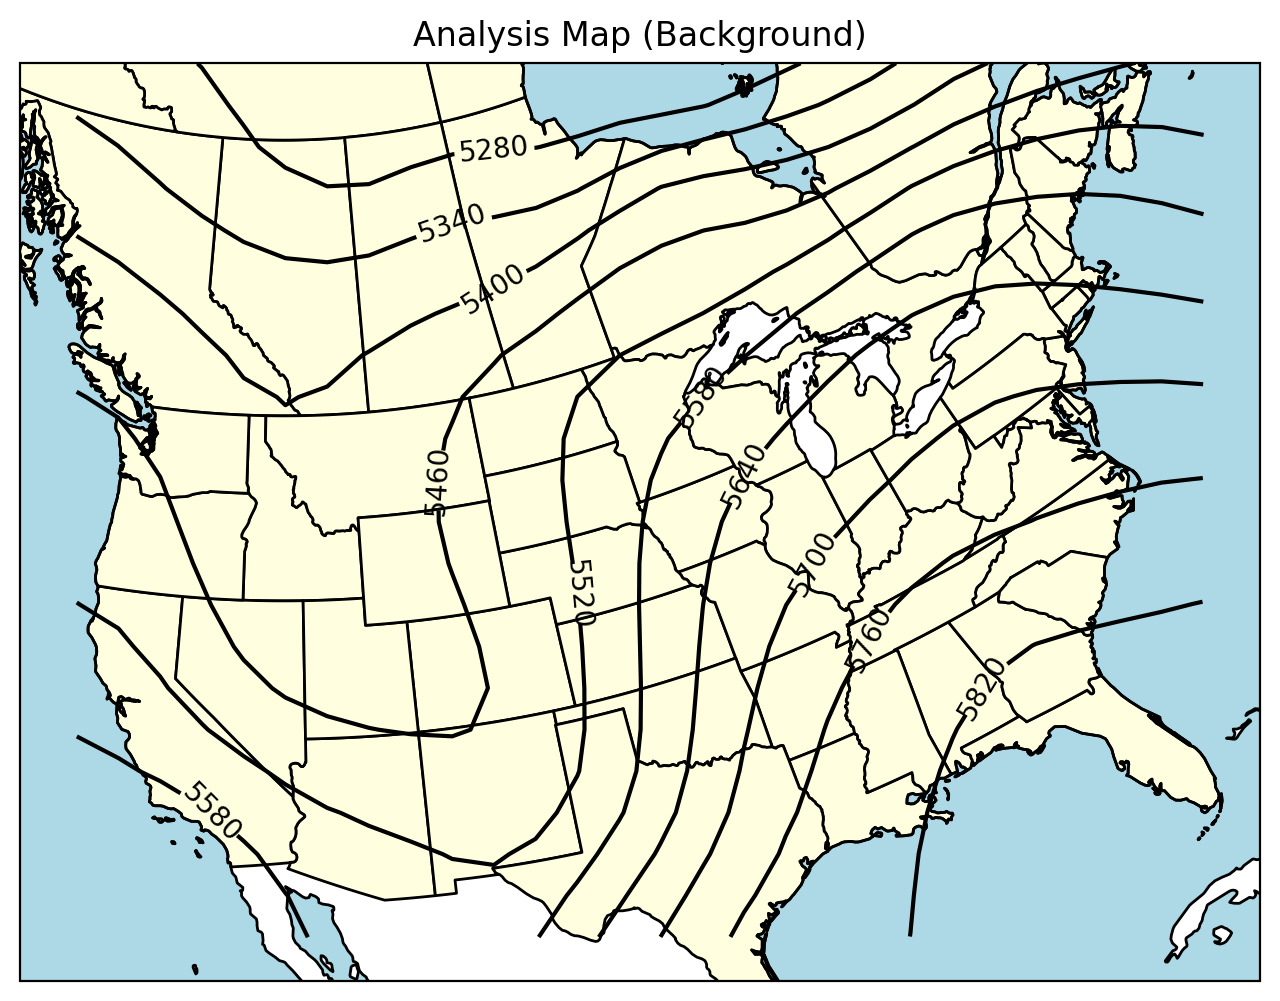

In [22]:
## Plot background field over a map ##
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')

## Plot analysis ##
cs1 = ax1.contour(Lon_g,Lat_g,background_matrix,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis Map (Background)')
plt.savefig("AnalysisBackground.png", dpi = 250)

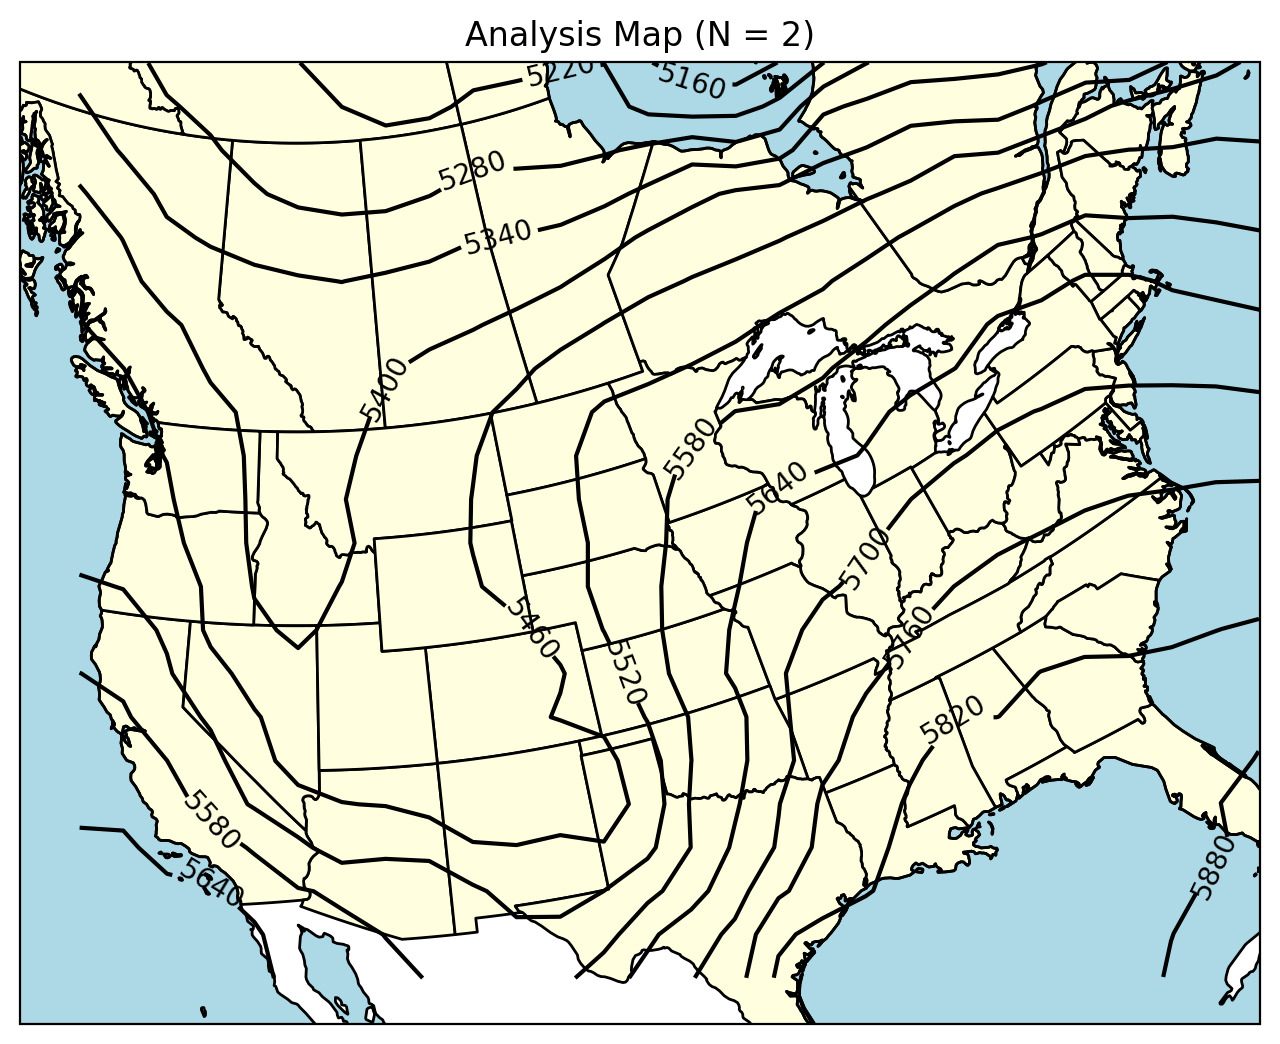

In [23]:
## Plot analysis N=2 over a map ##
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')

## Plot analysis ##
cs1 = ax1.contour(Lon_g,Lat_g,analysis2,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis Map (N = 2)')
plt.savefig("AnalysisN2.png", dpi = 250)

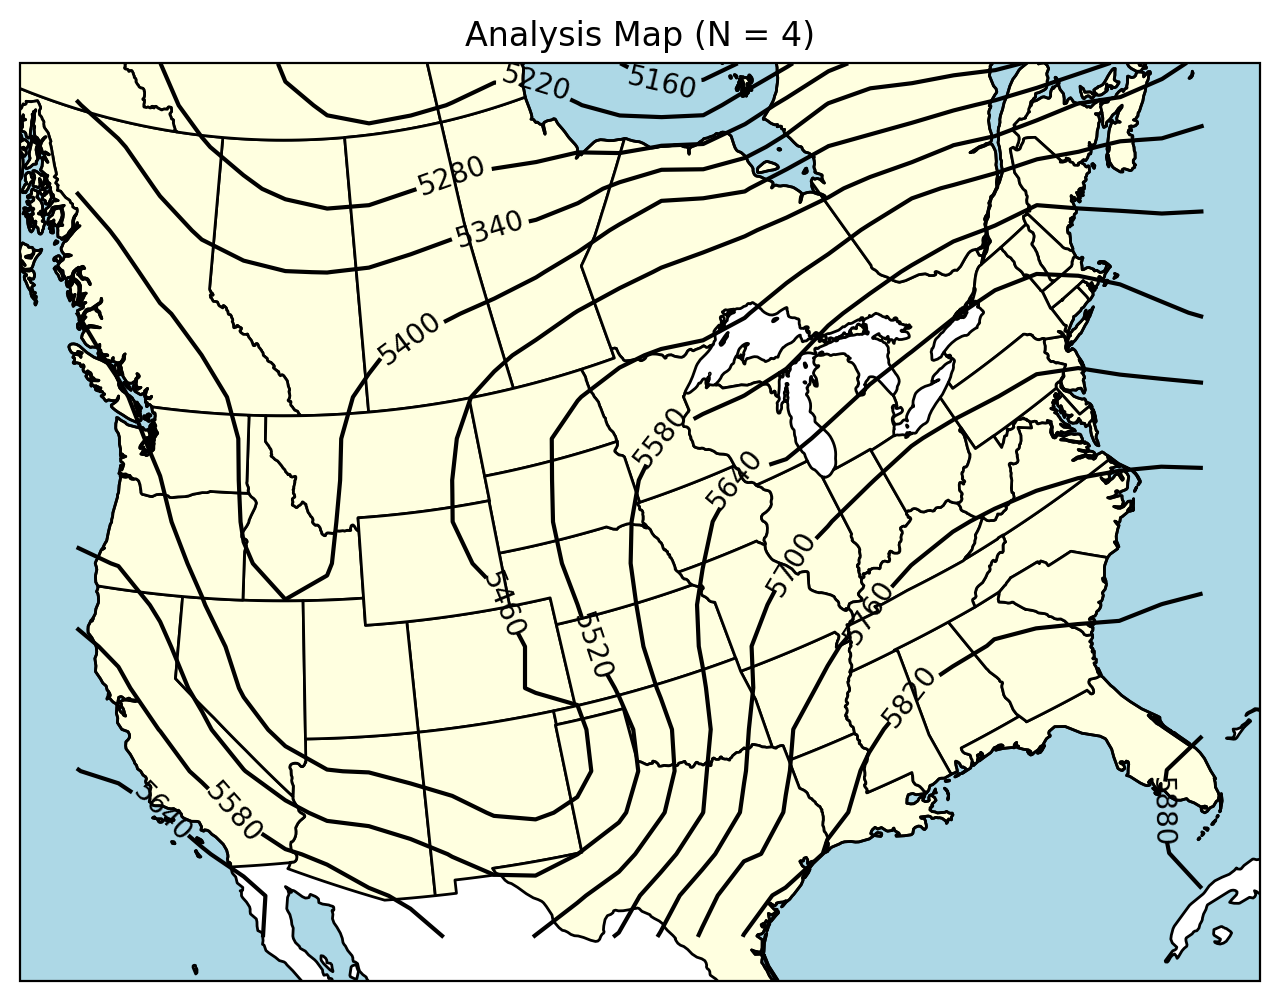

In [24]:
## Plot analysis N=4 over a map ##
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')

## Plot analysis ##
cs1 = ax1.contour(Lon_g,Lat_g,analysis4,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis Map (N = 4)')
plt.savefig("AnalysisN4.png", dpi = 250)

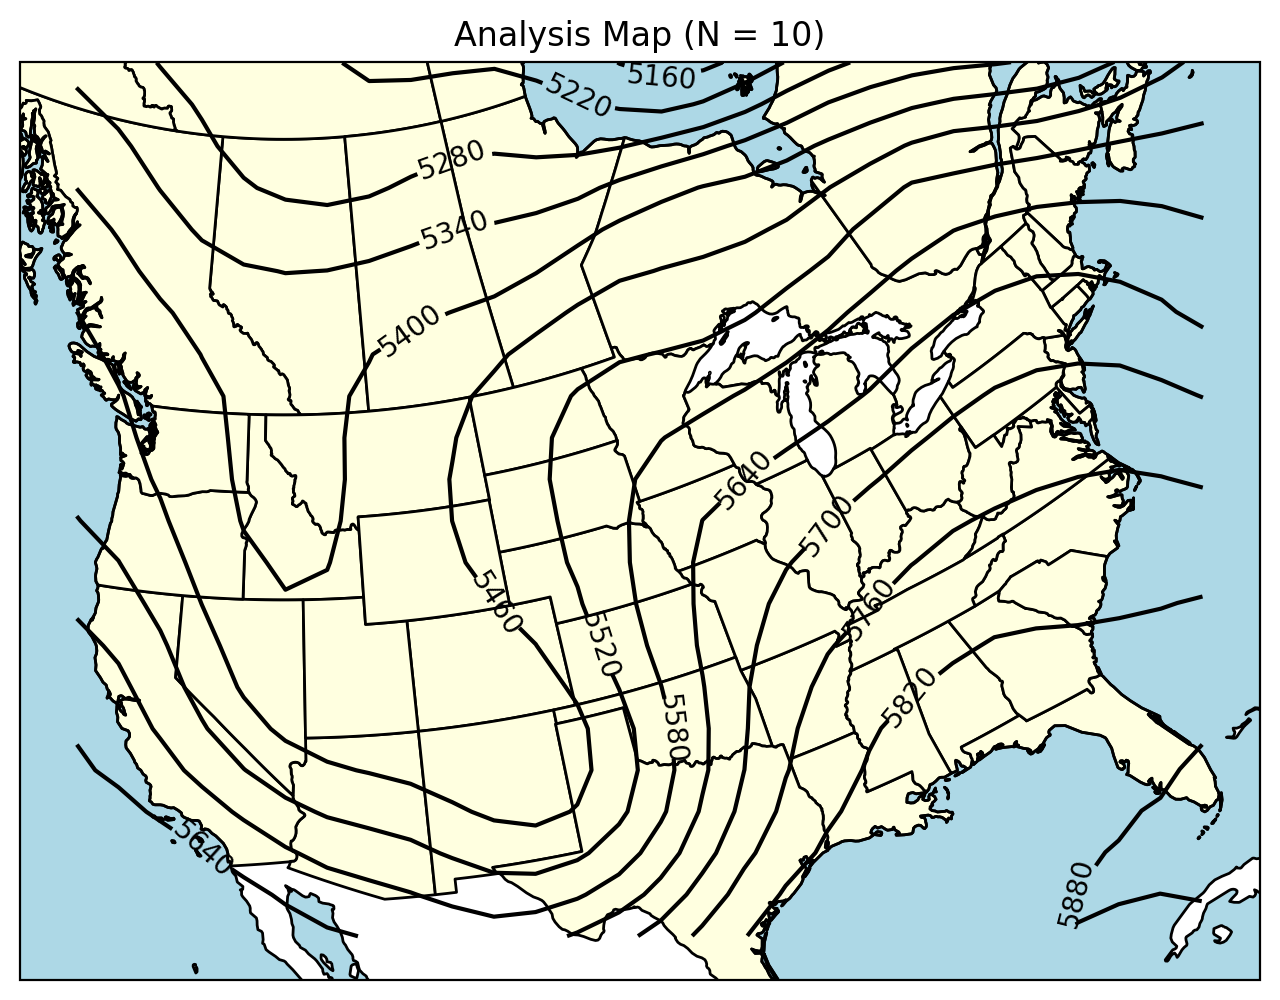

In [49]:
## Plot Analysis N=10 over a map ##
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')

## Plot analysis ##
cs1 = ax1.contour(Lon_g,Lat_g,analysis10,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis Map (N = 10)')
plt.savefig("AnalysisN10.png", dpi = 250)

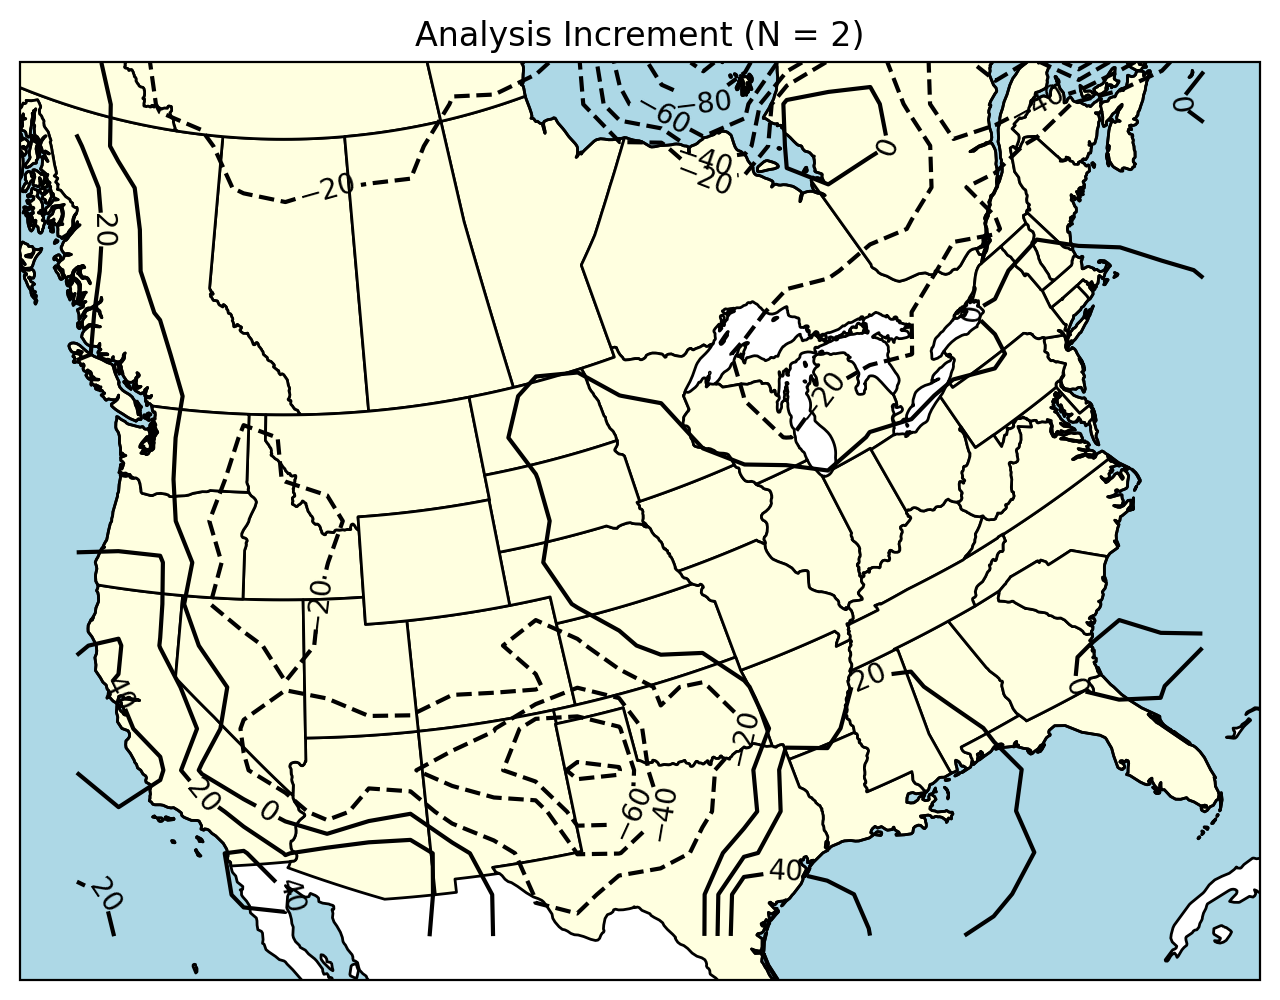

In [25]:
### Plot Increment N=2 over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')

## Plot analysis ##
cs1 = ax1.contour(Lon_g,Lat_g,analysis_inc2,colors='k',levels=np.arange(-8000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,20))
plt.title('Analysis Increment (N = 2)')
plt.savefig("AnalysisIncN2.png", dpi = 250)

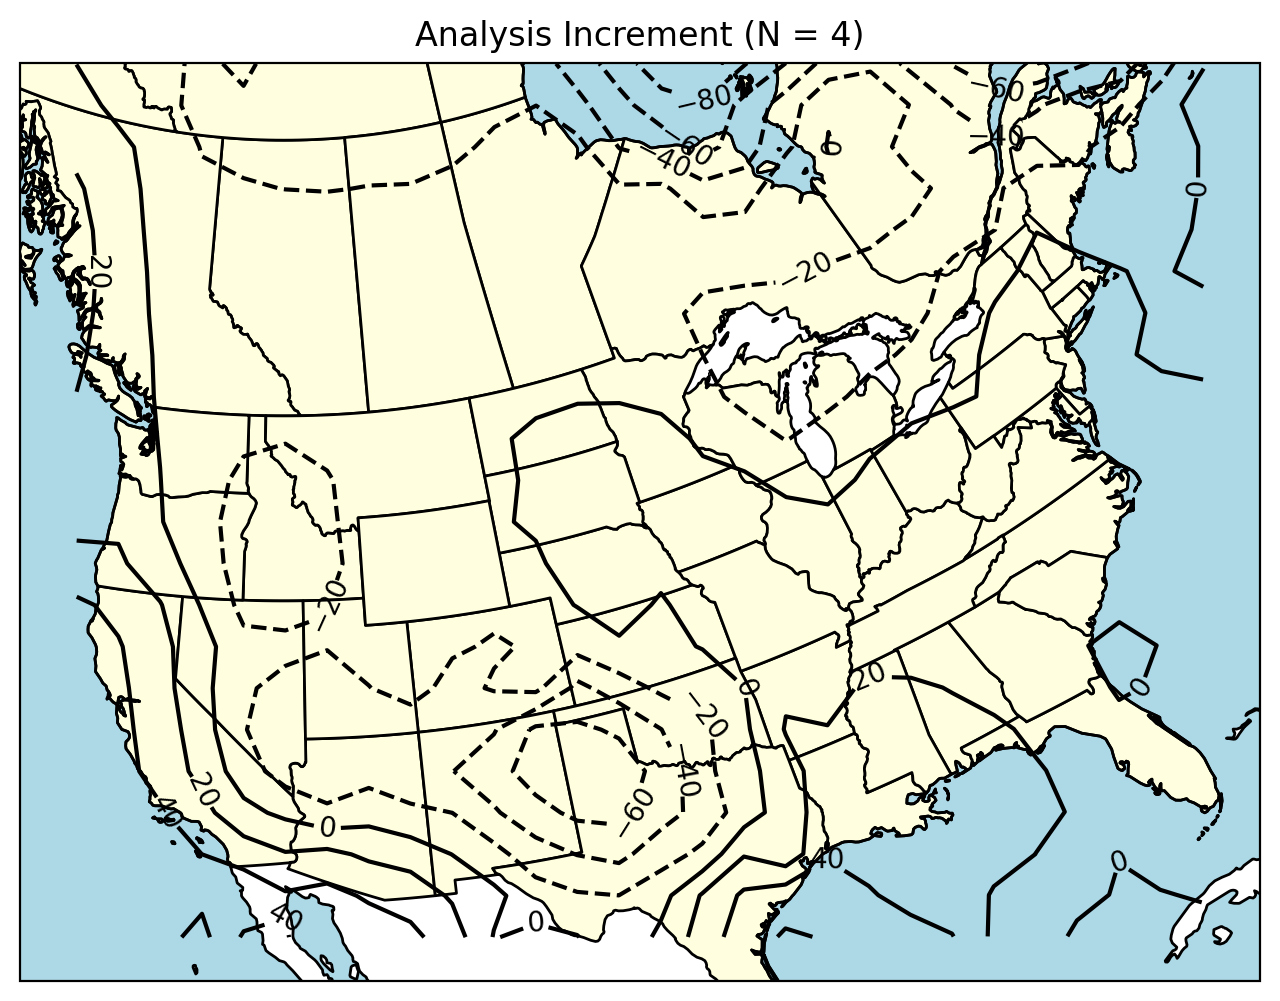

In [26]:
### Plot Increment N=4 over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')

## Plot analysis ##
cs1 = ax1.contour(Lon_g,Lat_g,analysis_inc4,colors='k',levels=np.arange(-8000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,20))
plt.title('Analysis Increment (N = 4)')
plt.savefig("AnalysisIncN4.png", dpi = 250)

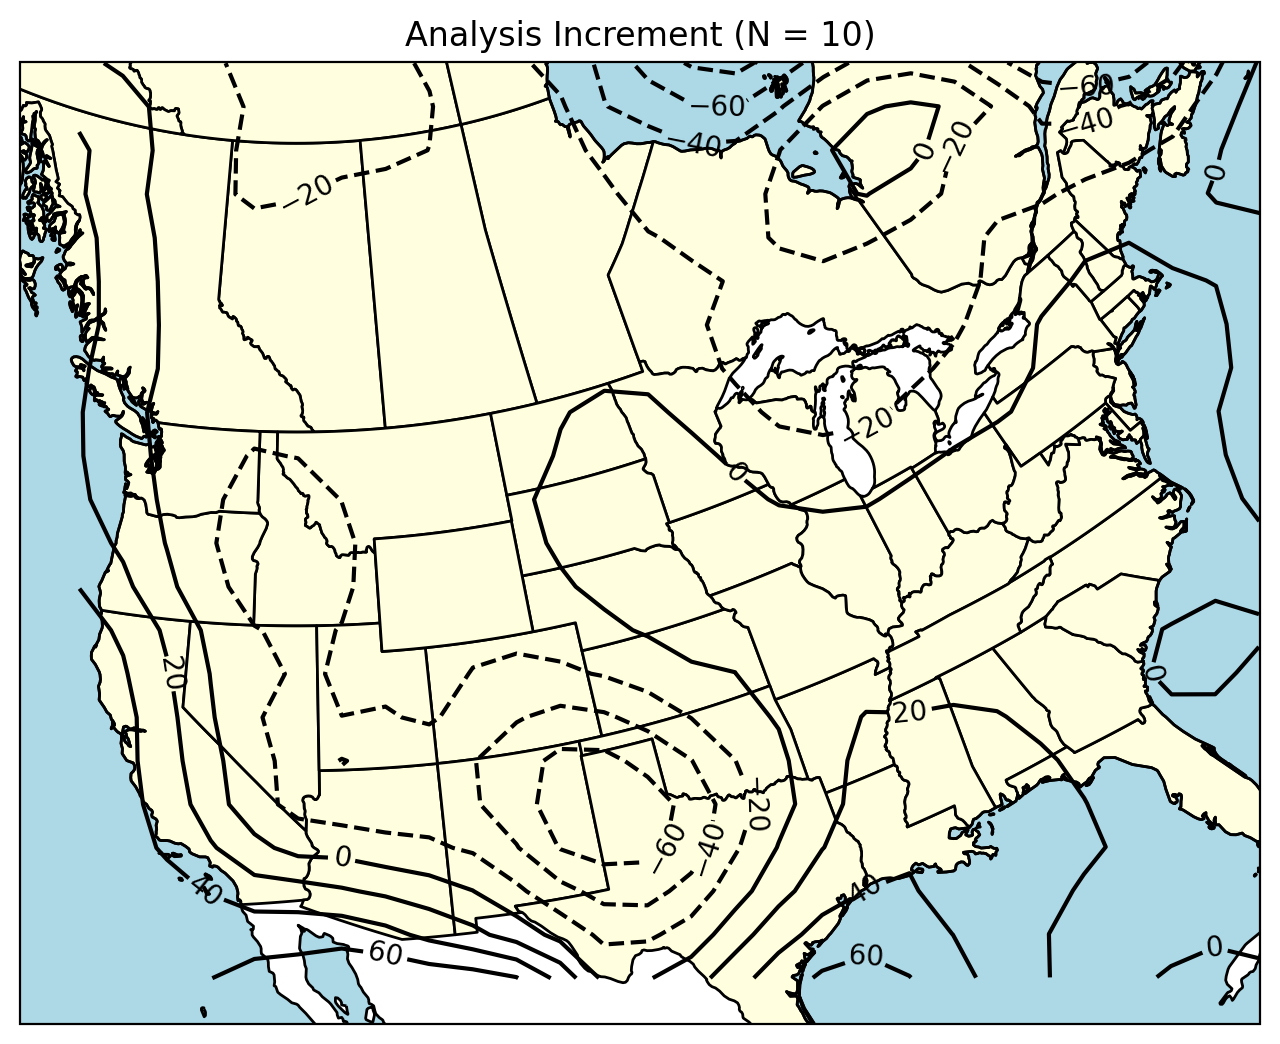

In [27]:
### Plot Increment N=10 over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')

## Plot analysis ##
cs1 = ax1.contour(Lon_g,Lat_g,analysis_inc10,colors='k',levels=np.arange(-8000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,20))
plt.title('Analysis Increment (N = 10)')
plt.savefig("AnalysisIncN10.png", dpi = 250)

In [ ]:
## EVERYTHING BELOW HERE IS SAVING FILES ##

In [34]:
file1_n2 = open("AnalysisN2", "w+")
file1_n4 = open("AnalysisN4", "w+")
file1_n10 = open("AnalysisN10", "w+")
analysis2_txt = str(analysis2)
analysis4_txt = str(analysis4)
analysis10_txt = str(analysis10)
file1_n2.write(analysis2_txt)
file1_n4.write(analysis4_txt)
file1_n10.write(analysis10_txt)
file1_n2.close()
file1_n4.close()
file1_n10.close()

file1_incn2 = open("IncrementN2", "w+")
file1_incn4 = open("IncrementN4", "w+")
file1_incn10 = open("IncrementN10", "w+")
incn2_txt = str(analysis_inc2)
incn4_txt = str(analysis_inc4)
incn10_txt = str(analysis_inc10)
file1_incn2.write(incn2_txt)
file1_incn4.write(incn4_txt)
file1_incn10.write(incn10_txt)
file1_incn2.close()
file1_incn4.close()
file1_incn10.close()

file1_incn2 = open("DifferenceN2", "w+")
file1_incn4 = open("DifferenceN4", "w+")
file1_incn10 = open("DifferenceN10", "w+")
incn2_txt = str(analysis_inc2)
incn4_txt = str(analysis_inc4)
incn10_txt = str(analysis_inc10)
file1_incn2.write(incn2_txt)
file1_incn4.write(incn4_txt)
file1_incn10.write(incn10_txt)
file1_incn2.close()
file1_incn4.close()
file1_incn10.close()

file1_diff2 = open("Diff2", "w+")
file1_diff4 = open("Diff4", "w+")
file1_diff10 = open("Diff10", "w+")
diff2_txt = str(diff1)
diff4_txt = str(diff2)
diff10_txt = str(diff3)
file1_diff2.write(diff2_txt)
file1_diff4.write(diff4_txt)
file1_diff10.write(diff10_txt)
file1_diff2.close()
file1_diff4.close()
file1_diff10.close()

file1_rms = open("RMSOutput", "w+")
rms_txt = str(rmsarray)
file1_rms.write(rms_txt)
file1_rms.close()

In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
Similar to previous assignments, there is a trough over the western US and a ridge over the eastern US. The trough is deeper and more noticable than the ridge. 
    
2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
All of the analyses seem really similar to each other, although the trough is slightly less deep with more values included and it seems a bit smoother (most noticably the jagged contour over Colorado isn't there with N=10. 
More observations included (with the 10 closest in this example), the analysis values are more representative and even (if thats the correct word) than the rougher values using only 2 points. 
    
3 - What happens as you increase the number of points considered for the analysis?  Is this 
    desirable?  Why or why not?
Adding points considered didn't really change the analysis, since the background was always involved, but eventually it would likely becoming overfit. Despite this, the plots will always look rather similar. 
'''